# Understanding Tesco Mobile reviews on Trustpilot

The scope of this project includes:
* scraping reviews from TrustPilot
* training an NLP model to predict the sentiment of a new review 
* categorise reviews and track their scores over time 

In [1]:
# import basic modules
import pandas as pd
import numpy as np 
import requests

## Step 1a: Scraping reviews with BeautifulSoup

In [2]:
from bs4 import BeautifulSoup
import json
import re 

### Development: extract reviews only from the first page

In [3]:
# URL
URL = 'https://uk.trustpilot.com/review/tescomobile.com?page=1'

In [4]:
# get the contents of the first page 
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [5]:
# find all containers with reviews (20x per page)
review_cards = soup.find_all('div', class_='review-card')
review_cards_json = soup.find_all('script', {'data-initial-state':'review-info'})

In [6]:
# instantiate empty lists
review_id = []
published_date = []
updated_date = []
reported_date = []
review_stars = []
review_text = []

for card in review_cards:
    # extract review id
    rid = card.find('article', {'class':'review'})['id']

    # extract review dates 
    review_dates_json = card.find('script', {'data-initial-state':'review-dates'})
    review_dates = json.loads(''.join(str(c) for c in review_dates_json.contents))
    pub_date = review_dates['publishedDate']
    upd_date = review_dates['updatedDate']
    rep_date = review_dates['reportedDate']

    # extract star rating 
    star_rating = card.find('div', class_='star-rating').find('img')['alt']
    stars = int(re.findall(r'\d', star_rating)[0])

    # extract review text 
    review_content = card.find('p', class_='review-content__text').text.strip()

    # append extracted information
    review_id.append(rid)
    published_date.append(pub_date)
    updated_date.append(upd_date)
    reported_date.append(rep_date)
    review_stars.append(stars)
    review_text.append(review_content)

In [7]:
# inspect
review_stars

[1, 5, 5, 1, 1, 1, 1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1, 5, 5]

In [8]:
# create a DataFrame
df = pd.DataFrame({
    'review_id': review_id, 
    'published_date': published_date,
    'updated_date': updated_date,
    'reported_date': reported_date,
    'stars': review_stars,
    'review_text': review_text})

# inspect
df.head()

,review_id,published_date,updated_date,reported_date,stars,review_text
0,5f50b0b202e85708c8ded2b2,2020-09-03T09:00:34Z,None,None,1,I have a sim only contract with Tesco. I wonde...
1,5f500e0702e85708c8de960a,2020-09-02T21:26:31Z,None,None,5,I have been with Tesco Mobile 1 year and I can...
2,5f4d936d02e8570814fd0908,2020-09-01T00:18:53Z,None,None,5,ive been with Tesco sim only plan for over a d...
3,5f4cece702e8570814fc9996,2020-08-31T12:28:23Z,None,None,1,No signal coverage where my vodaphone account ...
4,5f4b850e02e8570814fc02d7,2020-08-30T10:53:02Z,2020-09-02T21:16:40Z,None,1,"Can't top up my pay as you go account online, ..."


### Production: Create functions to extract pages of reviews

In [9]:
# create a function to loop across pages and extract information from them
def scrape_trustpilot(url, num_pages=1):
    """ Scrape n pages of reviews from Truspilot starting from the oldest in the range."""
    
    for i in range(num_pages, 0, -1):
        # construct URL
        url_fin = url + '?page=' + str(i)
        
        # get the contents of the first page 
        print(f'Page: {i:3} ...', end=' ')
        page = requests.get(url_fin)
        soup = BeautifulSoup(page.content, 'html.parser') 
        
        # find all review cards
        review_cards = soup.find_all('div', class_='review-card')
        
        # 
        extract_one_page(review_cards)
        print('done')
        

# create a function to scrape each page 
def extract_one_page(review_cards):
    for card in review_cards:
        # extract review id
        rid = card.find('article', {'class':'review'})['id']
        
        # extract review dates 
        review_dates_json = card.find('script', {'data-initial-state':'review-dates'})
#         review_dates = json.loads(review_dates_json.text)
        review_dates = json.loads(''.join(str(c) for c in review_dates_json.contents))
        pub_date = review_dates['publishedDate']
        upd_date = review_dates['updatedDate']
        rep_date = review_dates['reportedDate']
        
        # extract star rating 
        star_rating = card.find('div', class_='star-rating').find('img')['alt']
        stars = int(re.findall(r'\d', star_rating)[0])
        
        # extract review text 
        # sometimes, review text can be None
        try:
            review_content = card.find('p', class_='review-content__text').text.strip()
        except:
            review_content = np.nan
        
        # append extracted information
        review_id.append(rid)
        published_date.append(pub_date)
        updated_date.append(upd_date)
        reported_date.append(rep_date)
        review_stars.append(stars)
        review_text.append(review_content)
        
def clear_contents():
#     global review_id, published_date
    list_of_globals = globals()
    list_of_globals['review_id'] = []
    list_of_globals['published_date'] = []
    list_of_globals['updated_date'] = []
    list_of_globals['reported_date'] = []
    list_of_globals['review_stars'] = []
    list_of_globals['review_text'] = []
    
    list_of_globals['df'] = pd.DataFrame()

In [10]:
# extract reviews
# at most tried with 40 pages and it worked ok 
clear_contents()
scrape_trustpilot('https://uk.trustpilot.com/review/tescomobile.com', num_pages=5)

Page:   5 ... done
Page:   4 ... done
Page:   3 ... done
Page:   2 ... done
Page:   1 ... done


In [11]:
# create a DataFrame
df = pd.DataFrame({
    'review_id': review_id, 
    'published_date': published_date,
    'updated_date': updated_date,
    'reported_date': reported_date,
    'stars': review_stars,
    'review_text': review_text})

# inspect
df.head()

,review_id,published_date,updated_date,reported_date,stars,review_text
0,5f0354343f06f20658d3978a,2020-07-06T16:41:24Z,None,None,1,Bought an Acatel mobile (£24.99) for my elderl...
1,5f02bb7d3f06f20a94d9814f,2020-07-06T05:49:49Z,None,None,1,"Steer clear if these highway robbers, if they ..."
2,5f01e1653f06f20a94d92bd3,2020-07-05T14:19:17Z,2020-07-06T15:27:03Z,None,1,Cant remember a worst experience ever!! Shock...
3,5f0054133f06f20658d1e62b,2020-07-04T10:04:03Z,None,None,1,Like 1000s of others I am a victim of this com...
4,5f003e983f06f20a94d85d5a,2020-07-04T08:32:24Z,None,None,1,I didn't even had the chance to enjoy being th...


In [12]:
# parse dates 
date_cols = ['published_date','updated_date','reported_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [13]:
# inspect stats 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   review_id       100 non-null    object             
 1   published_date  100 non-null    datetime64[ns, UTC]
 2   updated_date    29 non-null     datetime64[ns, UTC]
 3   reported_date   0 non-null      datetime64[ns]     
 4   stars           100 non-null    int64              
 5   review_text     100 non-null    object             
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), int64(1), object(2)
memory usage: 4.8+ KB


In [ ]:
# export data to .csv
df.to_csv('../data/tp_reviews_20180915_20200830.csv', index=False)

### Data Validation (draft)

In [14]:
# oldest review
df['published_date'].min()

Timestamp('2020-06-26 10:08:40+0000', tz='UTC')

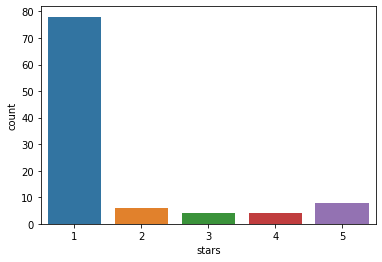

In [15]:
# distribution of star ratings 
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.countplot(df['stars'])

In [16]:
# average star rating 
df['stars'].mean()

1.58

Text(0.5, 1.0, 'Average rating of new reviews')

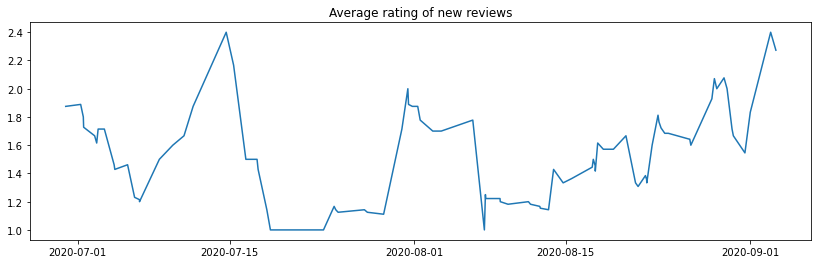

In [17]:
# average rating by day
ratings = df[['published_date','stars']].sort_values('published_date').set_index('published_date')
daily_average_7 = ratings.rolling('7D').mean()

# plot it 
plt.figure(figsize=(14,4))
plt.plot(daily_average_7[7:])

# annotate it 
plt.title('Average rating of new reviews')

In [18]:
df[df['review_text'].isna()]

,review_id,published_date,updated_date,reported_date,stars,review_text
